In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools

from scipy.stats import multivariate_normal

class Gaussian(object):
    def __init__(self, mean=[0], cov=[1]):
        self.mean = np.array(mean)
        self.cov = np.array(cov)
        self.rv = multivariate_normal(mean=self.mean, cov=self.cov)
        self.n_features = len(mean)
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return self.rv.pdf(x)
    
    def sample(self, size=None, **kwargs):
        return self.rv.rvs(size)
    
    def __str__(self):
        return 'Gaussian(mean = {}, cov = {})'.format(self.mean, self.cov)
    
class MixtureDistribution(object):
    def __init__(self, priors, distributions):
        self.priors = np.array(priors)
        self.distributions = distributions
        
    def sample(self, size=None):
        if size is None:
            size = len(self.priors)
        classes = np.random.multinomial(n=1, pvals=self.priors, size=size)
        samples = np.zeros((size, self.distributions[0].n_features))
        for i, size in enumerate(classes.sum(axis=0)):
            samples[np.where(classes[:,i])[0]] = self.distributions[i].sample(size).reshape(-1, self.distributions[0].n_features)
        return samples, classes
    
    def posterior(self, x):
        likelihoods = np.array([d.pdf(x) for d in self.distributions])
        Z = np.dot(self.priors, likelihoods).reshape(-1,1)
        return np.divide(likelihoods.T*self.priors, Z)
    
    def pdf(self, x):
        likelihoods = np.array([d.pdf(x) for d in self.distributions])
        return np.dot(self.priors, likelihoods)

    def __repr__(self):
        string = ''
        for p, d in zip(self.priors, self.distributions):
            string += 'prior = {:.2f}, '.format(p)
            string += 'Distribution = {}'.format(d)
            string += '\n'
        return string
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

In [2]:
plt.rcParams['figure.figsize'] = (16, 5)

n_samples = 1000
grid_levels = 200

# 1. Mixture of Multivariate Gaussian distribution

prior = 0.33, Distribution = Gaussian(mean = [0 0], cov = [[1 0]
 [0 1]])
prior = 0.33, Distribution = Gaussian(mean = [0.5 0.5], cov = [[ 0.5  -0.25]
 [-0.25  0.5 ]])
prior = 0.33, Distribution = Gaussian(mean = [-0.5  0.5], cov = [[0.5  0.25]
 [0.25 0.5 ]])



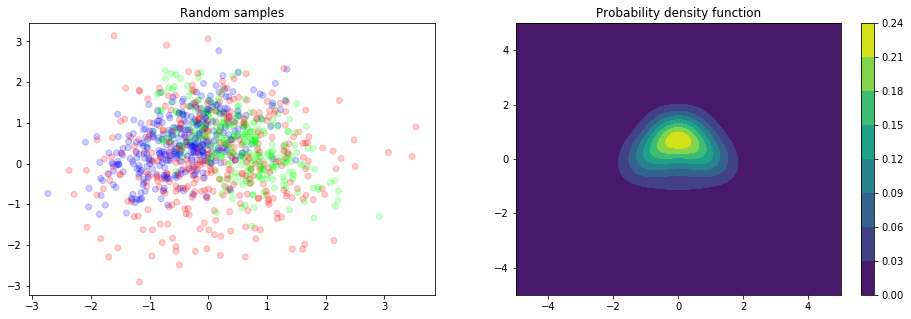

In [3]:
prior = [1/3, 1/3, 1/3]
a = 0.5
b = 0.5
c = 0.25

x_grid = np.linspace(-5, 5, grid_levels)
y_grid = np.linspace(-5, 5, grid_levels)

mg = MixtureDistribution(priors=prior,
                         distributions=[Gaussian([0, 0], [[1, 0], [0, 1]]),
                                        Gaussian([+a, +a], [[+b, -c], [-c, +b]]),
                                        Gaussian([-a, +a], [[+b, +c], [+c, +b]])])

print(mg)

x, y = mg.sample(n_samples)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('Random samples')
ax1.scatter(x[:,0], x[:,1], color=y, alpha=0.2)

xx, yy = np.meshgrid(x_grid, y_grid)
z = mg.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)

ax2 = fig.add_subplot(122)
ax2.set_title('Probability density function')
contour = ax2.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
fig.colorbar(contour)

## 1.a. Individual probability density functions

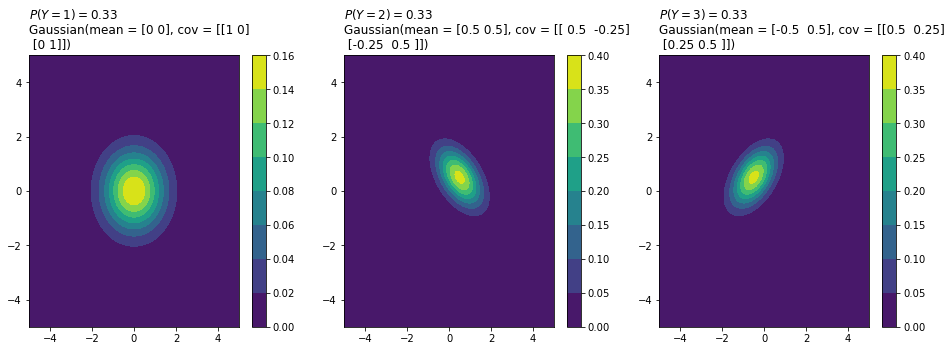

In [4]:
def plot_individual_pdfs(class_dist):
    fig = plt.figure()
    xx, yy = np.meshgrid(x_grid, y_grid)

    for i, (p, d) in enumerate(zip(class_dist.priors, class_dist.distributions)):
        z = d.pdf(np.vstack([xx.flatten(), yy.flatten()]).T)
        
        ax = fig.add_subplot(1, len(class_dist.distributions), i+1)
        ax.set_title('$P(Y={})={:.2f}$\n{}'.format(i+1, p, str(d)), loc='left')
        contour = ax.contourf(xx, yy, z.reshape(grid_levels,grid_levels))
        fig.colorbar(contour)
        
plot_individual_pdfs(mg)

## 1.b. Individual posterior probabilities

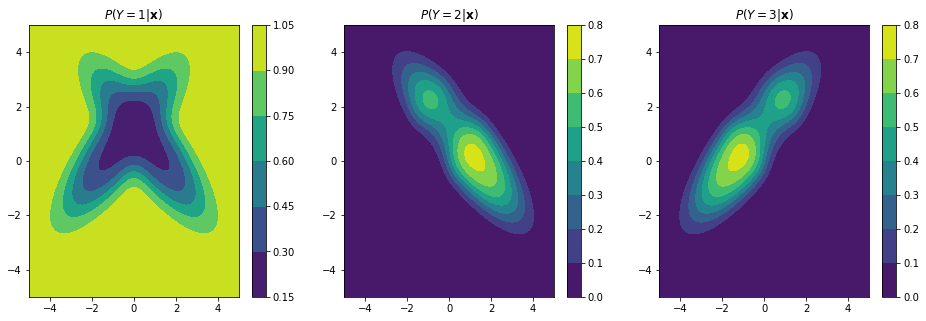

In [5]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = mg.posterior(np.vstack([xx.flatten(), yy.flatten()]).T)
    
for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

# 2. Training a Gaussian Naive Bayes

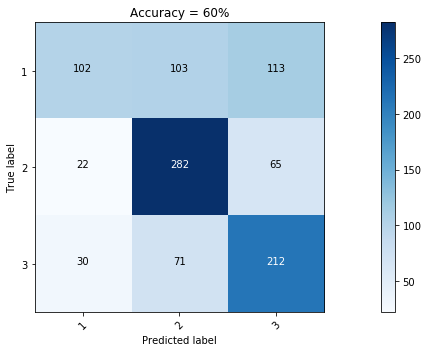

In [6]:
from sklearn.naive_bayes import GaussianNB

x, y_bin = mg.sample(n_samples)
y = np.argmax(y_bin, axis=1)
gnb = GaussianNB()
y_pred = gnb.fit(x, y).predict(x)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)

plot_confusion_matrix(cm, classes=['1', '2', '3'], title="Accuracy = {:.0f}%".format((y == y_pred).mean()*100))

## 2.a. Individual predicted posterior probabilities

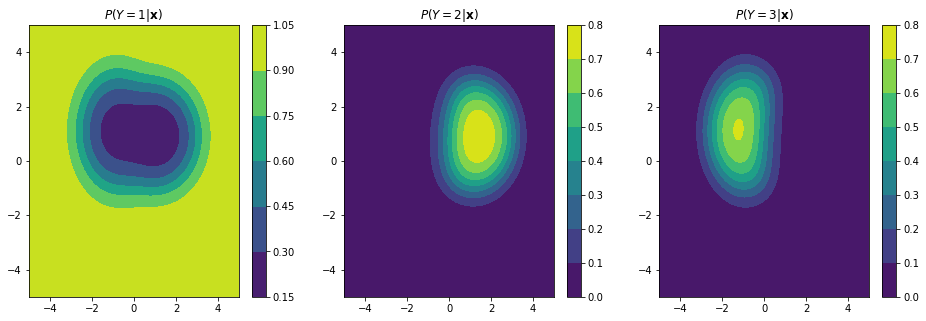

In [7]:
fig = plt.figure()
xx, yy = np.meshgrid(x_grid, y_grid)

Z = gnb.predict_proba(np.vstack([xx.flatten(), yy.flatten()]).T)

for i in [0, 1, 2]: 
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1))

    contour = ax.contourf(xx, yy, Z[:,i].reshape(grid_levels,grid_levels))
    fig.colorbar(contour)

## 2.b. Histogram of predicted probabilities for each Actual class

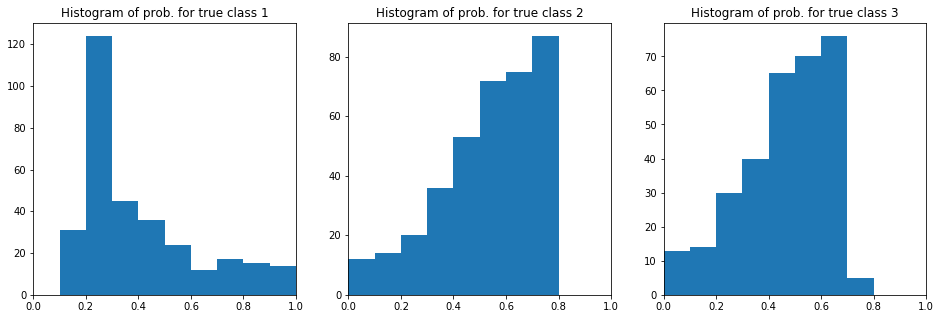

In [8]:
p_pred = gnb.predict_proba(x)

fig = plt.figure()
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('Histogram of prob. for true class {}'.format(i+1))
    ax.hist(p_pred[y == i, i], range=(0, 1))
    ax.set_xlim(0, 1)

## 2.c. 2D Histogram of paired predicted probabilities for each Actual class

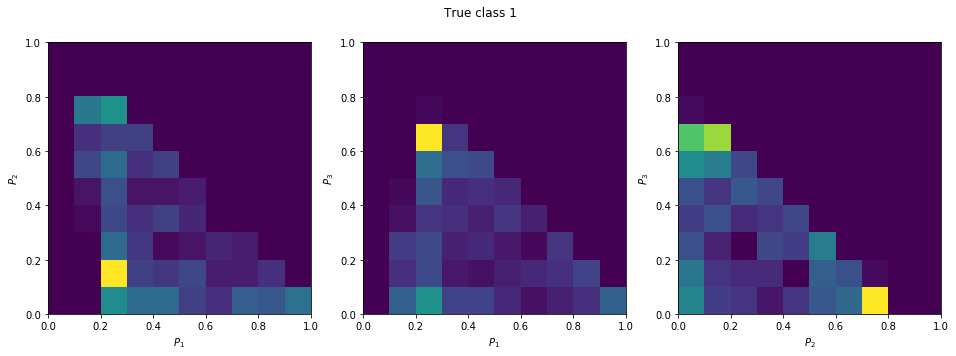

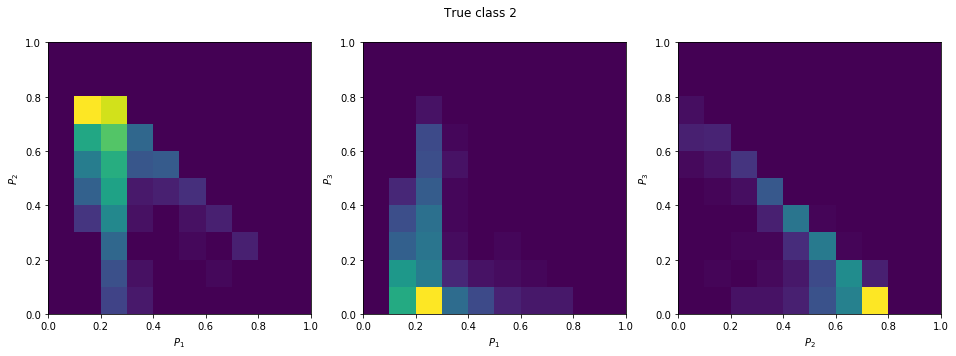

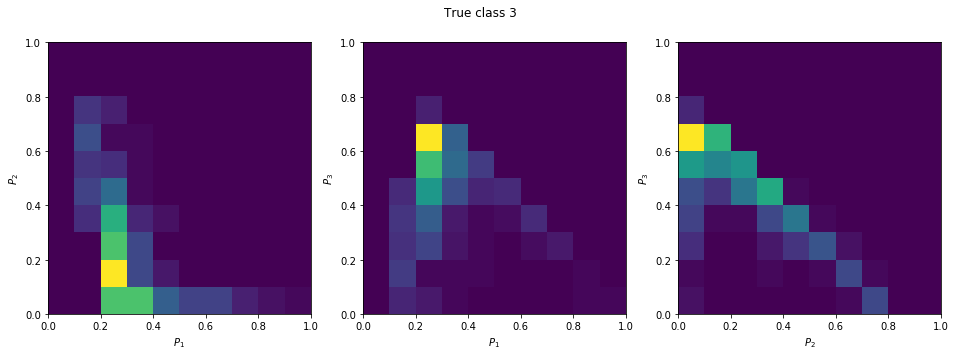

In [9]:
from itertools import combinations

for true_class in [0, 1, 2]:
    fig = plt.figure()
    fig.suptitle('True class {}'.format(true_class+1))
    for i, (cx, cy) in enumerate(combinations([0, 1, 2], 2)):
        ax = fig.add_subplot(1, 3, i+1)
        ax.hist2d(p_pred[y == true_class, cx], p_pred[y == true_class, cy],
                  bins=10, range=[[0, 1], [0, 1]])
        ax.set_xlabel(r'$P_{}$'.format(cx+1))
        ax.set_ylabel(r'$P_{}$'.format(cy+1))